# Fluid Simulation with Cosmic Rays

## Imports

In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt

from jf1uids import SPHERICAL, CARTESIAN
from jf1uids import SimulationConfig
from jf1uids import SimulationParams
from jf1uids import get_helper_data
from jf1uids import get_primitive_state_with_crs
from jf1uids import get_registered_variables

from jf1uids import time_integration

## Simulation Setup

Let us set up a very simple simulation, mostly with default parameters - except for the inclusion of Cosmic Rays.

In [2]:
config = SimulationConfig(
    geometry = SPHERICAL,
    num_cells = 1001,
    simplified_cosmic_rays = True
)

Next we setup the simulation parameters, things we might vary

In [3]:
params = SimulationParams(
    t_end = 0.2 # the typical value for a shock test
)

With this we generate some helper data, like the cell centers etc.

In [4]:
helper_data = get_helper_data(config)
registered_variables = get_registered_variables(config)

Next we setup the shock initial conditions

In [5]:
shock_pos = 0.5
r = helper_data.geometric_centers
rho = jnp.where(r < shock_pos, 1.0, 0.2)
u = jnp.zeros_like(r)
p_gas = jnp.where(r < shock_pos, 2.0, 0.02)

# cosmic ray setup
p_cr = jnp.where(r < shock_pos, 1.0, 0.1)
gamma_cr = 4/3
n_cr = p_cr ** (1/gamma_cr)

# get initial state
initial_state = get_primitive_state_with_crs(rho, u, p_gas, p_cr, registered_variables)

## Running the simulation

In [6]:
final_state = time_integration(initial_state, config, params, helper_data, registered_variables)
rho_final = final_state[registered_variables.density_index]
u_final = final_state[registered_variables.velocity_index]
p_final = final_state[registered_variables.pressure_index]
n_cr_final = final_state[registered_variables.cosmic_ray_n_index]
p_cr_final = n_cr_final ** gamma_cr
p_gas_final = p_final - p_cr_final

## Visualization

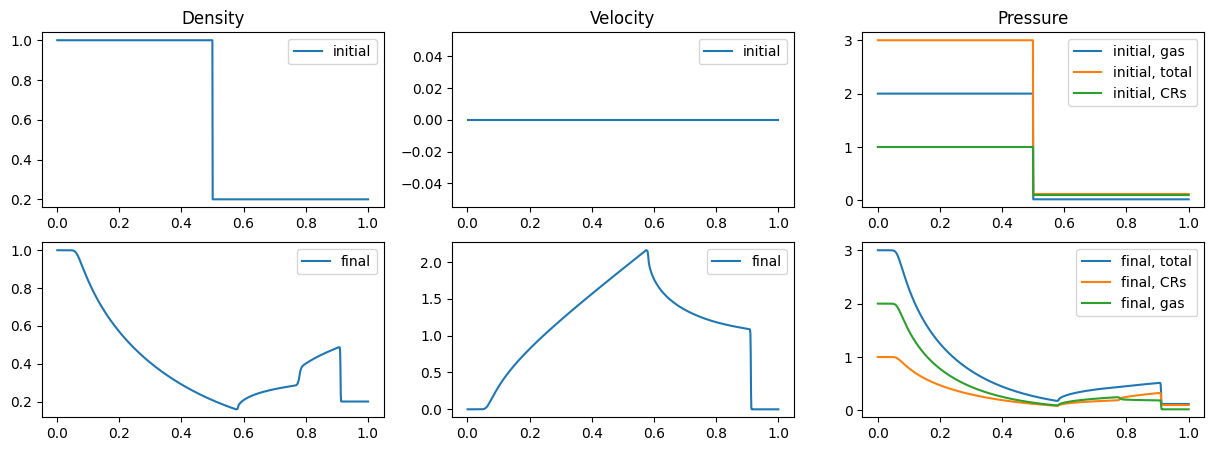

In [7]:
fig, axs = plt.subplots(2, 3, figsize=(15, 5))

axs[0, 0].plot(r, rho, label='initial')
axs[1, 0].plot(r, rho_final, label='final')
axs[0, 0].set_title('Density')
axs[0, 0].legend()
axs[1, 0].legend()

axs[0, 1].plot(r, u, label='initial')
axs[1, 1].plot(r, u_final, label='final')
axs[0, 1].set_title('Velocity')
axs[0, 1].legend()
axs[1, 1].legend()

axs[0, 2].plot(r, p_gas, label='initial, gas')
axs[0, 2].plot(r, p_gas + p_cr, label='initial, total')
axs[1, 2].plot(r, p_final, label='final, total')
axs[0, 2].plot(r, p_cr, label='initial, CRs')
axs[1, 2].plot(r, p_cr_final, label='final, CRs')
axs[1, 2].plot(r, p_gas_final, label='final, gas')

axs[0, 2].set_title('Pressure')
axs[0, 2].legend()
axs[1, 2].legend()